This tutorial queries the SDSS data base for galaxies, downloads a table with basic photometric properties of the galaxies and makes plots with the downloaded data

This tutorial is based on: https://escip.io/notebooks/sdss_tutorial_1.html 


## Objectives

To demonstrate ways of querying and visualizing data from the SDSS, using Python and SQL

In [1]:
import matplotlib
from matplotlib import pylab as plt
# accessing data from SkyView
from astroquery.skyview import SkyView
# standard astronomy packages
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

import pandas as pd # data analysis 
import numpy as np # more data analysis
import seaborn as sns # plotting library
from matplotlib import pyplot as plt # another plotting library
from astroquery.sdss import SDSS

# for 3 colour images
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import get_pkg_data_filename

In [2]:
# Make notebook have a clean appearance

pd.set_option('display.max_colwidth', None)
import warnings
warnings.filterwarnings('ignore')

## Obtaining data from SDSS 

We are using and SQL query to get data from the SDSS data base. In this case, we are getting photometry data (magnitudes and galaxy sizes).

In short, every SQL command consists of three blocks:

- The SELECT block: it defines the quantities that you want your query to return.
- The FROM block: it defines which tables of the database you want SQL to look in.
- The WHERE block: it defines any constraints on the data that you want to impose.

In [3]:
# SQL query

query = 'SELECT TOP 5000 p.objId, p.ra, p.dec, p.petror90_r, p.g, p.r ' # defining which measurments we want
query += 'FROM galaxy AS p ' # selecting the data table
query += 'WHERE p.u BETWEEN 0 AND 19.6'
query += 'AND p.g BETWEEN 0 AND 17  AND p.petror90_r > 10'
#print (query) # useful for debugging, remove first # to uncomment

# send query to SDSS
gals = SDSS.query_sql(query, data_release=16)

gals


objId,ra,dec,petror90_r,g,r
int64,float64,float64,float64,float64,float64
1237648673459077169,245.36735255391,-0.45707380877553,11.18379,16.31978,15.37991
1237648702991434184,240.47556848646,-1.21924737430151,11.74114,16.67211,15.67261
1237648703528305080,240.451904814574,-0.80913450918299,12.88677,15.353,14.55547
1237648704603095512,242.827660820925,0.214113730693306,10.64898,16.99265,15.94474
1237648705141015074,245.177247536337,0.516164657023886,10.60209,15.99065,15.33806
1237651249917198576,263.319017954923,21.3132631713323,11.50363,16.57463,15.58149
1237651249917198577,263.316125832189,21.3104901162357,12.3384,15.90051,15.18294
1237651249919099855,265.592771034565,17.4315756094545,11.82485,15.79165,14.8323
1237651251527942150,264.67508561332,21.6750915679742,29.99989,14.42247,13.5221


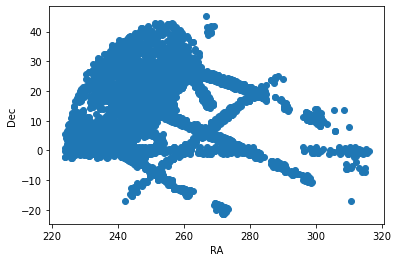

In [4]:
plt.scatter(gals['ra'], gals['dec'])
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()


In [5]:
gals.keys()

['objId', 'ra', 'dec', 'petror90_r', 'g', 'r']

## Colour - magnitude diagram

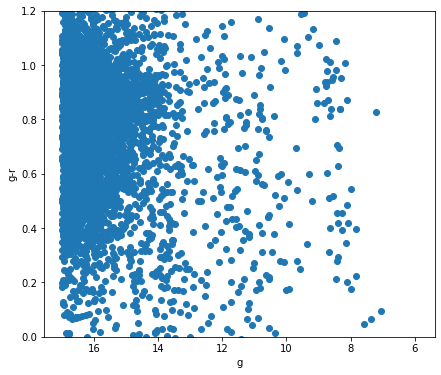

In [6]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)
plt.scatter(gals['g'], gals['g']-gals['r'])
plt.xlabel('g')
plt.ylabel('g-r')
ax.set_ylim(0, 1.2)
ax.invert_xaxis()
plt.show()

## Searching for "small" red galaxies

First lets identify a way of selecting red and "small" galaxies and red galaxies.


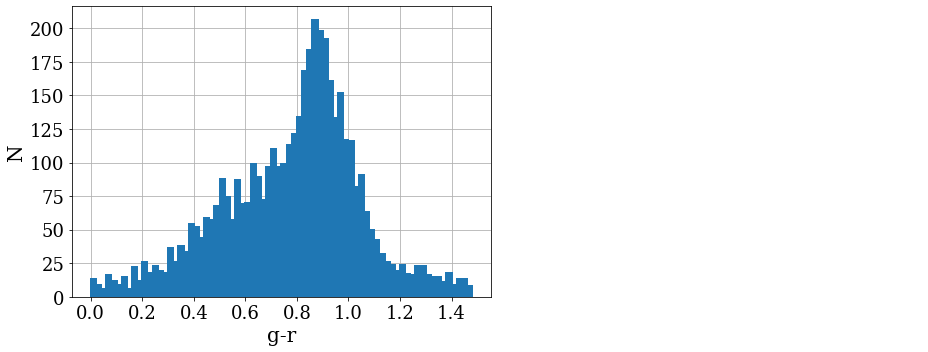

In [7]:
fig = plt.figure(figsize=(13.,5.))
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])

ax1 = fig.add_subplot(1,2,1)
d =  gals['g']-gals['r']
bin_size = np.arange(0,1.5,0.02) 
plt.hist(d, bins=bin_size, histtype='step', color='C0', fill=True, linewidth=2)
#plt.axvline(1/317.83, color='C1', lw=4, label='Earth')
plt.xticks(family='serif',size=18)
plt.yticks(family='serif',size=18)
ax1.set_xlabel('g-r', size=20,family='serif')
ax1.set_ylabel('N', size=20,family='serif')
plt.grid(True)
#plt.legend()
#plt.xlim(0.00,13)
plt.tight_layout()

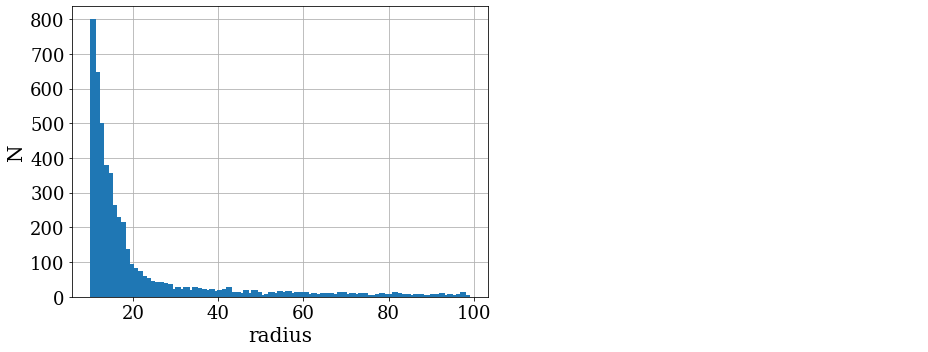

In [8]:
fig = plt.figure(figsize=(13.,5.))
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])

ax1 = fig.add_subplot(1,2,1)
d =  gals['petror90_r']
bin_size = np.arange(10,100,1) 
plt.hist(d, bins=bin_size, histtype='step', color='C0', fill=True, linewidth=2)
#plt.axvline(1/317.83, color='C1', lw=4, label='Earth')
plt.xticks(family='serif',size=18)
plt.yticks(family='serif',size=18)
ax1.set_xlabel('radius', size=20,family='serif')
ax1.set_ylabel('N', size=20,family='serif')
plt.grid(True)
#plt.legend()
#plt.xlim(0.00,13)
plt.tight_layout()

In [9]:
gals['g-r'] = gals['g']-gals['r']

#gals

In [10]:
red = gals[gals['g-r'] > 1]

In [11]:
#print(red)

In [12]:
small_red = red[red['petror90_r'] < 15]

In [13]:
#print(small_red)

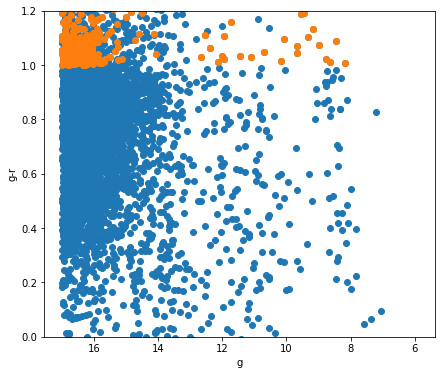

In [14]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)
plt.scatter(gals['g'], gals['g']-gals['r'])
plt.scatter(small_red['g'], small_red['g']-small_red['r'])
plt.xlabel('g')
plt.ylabel('g-r')
ax.set_ylim(0, 1.2)
ax.invert_xaxis()
plt.show()

## Lets get an image for one of our small red galaxies

We are going to use SkyView for this, since we know how it works

In [26]:
c = SkyCoord(ra=small_red['ra'][1]*u.degree, dec=small_red['dec'][1]*u.degree, frame='icrs')
print(c.ra.hms, c.dec)

path = SkyView.get_images(position=c, width=0.02*u.deg, height=0.02*u.deg, survey=['SDSSr'], pixels=[300,300])

hdulist_DSS2 = path[0]
d_DSS2 = hdulist_DSS2[0].data
h_DSS2 = hdulist_DSS2[0].header

hms_tuple(h=17.0, m=35.0, s=6.273303222731386) 25d06m12.42405607s


ReadTimeout: HTTPConnectionPool(host='skyview.gsfc.nasa.gov', port=80): Read timed out. (read timeout=None)

In [ ]:
plt.imshow(d_DSS2, cmap='Oranges', vmax=np.percentile(d_DSS2, 99.9))

## Let's make a 3 coulour image

This will help us evaluate what type of galaxy we have.


In [ ]:
path = SkyView.get_images(position=c, width=0.02*u.deg, height=0.02*u.deg, survey=['SDSSg'], pixels=[900,900])

# this line puts the data into a fits image
hdulist_SDSS_g = path[0]
d_SDSS_g = hdulist_SDSS_g[0].data
h_SDSS_g = hdulist_SDSS_g[0].header

path = SkyView.get_images(position=c, width=0.02*u.deg, height=0.02*u.deg, survey=['SDSSr'], pixels=[900,900])

# this line puts the data into a fits image
hdulist_SDSS_r = path[0]
d_SDSS_r = hdulist_SDSS_r[0].data
h_SDSS_r = hdulist_SDSS_r[0].header

path = SkyView.get_images(position=c, width=0.02*u.deg, height=0.02*u.deg, survey=['SDSSi'], pixels=[900,900])

# this line puts the data into a fits image
hdulist_SDSS_i = path[0]
d_SDSS_i = hdulist_SDSS_i[0].data
h_SDSS_i = hdulist_SDSS_i[0].header

In [ ]:
# assigning colours to the image layers
g = d_SDSS_g
r = d_SDSS_r
i = d_SDSS_i

# making a quick image
# A lower Q and stretch parameter make the fainter features in the image visible
rgb_default = make_lupton_rgb(i, r, g, Q=10, stretch=0.5, filename="test.jpeg")

# checking the data
plt.imshow(rgb_default, origin='lower')

### What type of galaxy is this?

## Lets look at some blue galaxies

In [19]:
blue = gals[gals['g-r'] < 0.7]
blue_2 = blue[blue['g-r'] > 0.4]

small_blue = blue_2[blue_2['petror90_r'] < 20]


In [21]:
print(len(small_blue))

821


In [22]:
c_blue = SkyCoord(ra=small_blue['ra'][1]*u.degree, dec=small_blue['dec'][1]*u.degree, frame='icrs')


In [23]:
path = SkyView.get_images(position=c_blue, width=0.02*u.deg, height=0.02*u.deg, survey=['SDSSg'], pixels=[300,300])

# this line puts the data into a fits image
hdulist_SDSS_g = path[0]
d_SDSS_g = hdulist_SDSS_g[0].data
h_SDSS_g = hdulist_SDSS_g[0].header

path = SkyView.get_images(position=c_blue, width=0.02*u.deg, height=0.02*u.deg, survey=['SDSSr'], pixels=[300,300])

# this line puts the data into a fits image
hdulist_SDSS_r = path[0]
d_SDSS_r = hdulist_SDSS_r[0].data
h_SDSS_r = hdulist_SDSS_r[0].header

path = SkyView.get_images(position=c_blue, width=0.02*u.deg, height=0.02*u.deg, survey=['SDSSi'], pixels=[300,300])

# this line puts the data into a fits image
hdulist_SDSS_i = path[0]
d_SDSS_i = hdulist_SDSS_i[0].data
h_SDSS_i = hdulist_SDSS_i[0].header

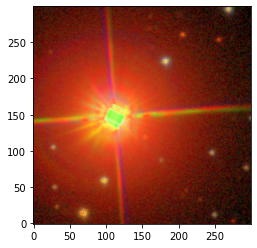

In [24]:
# assigning colours to the image layers
g = d_SDSS_g
r = d_SDSS_r
i = d_SDSS_i

# making a quick image
# A lower Q and stretch parameter make the fainter features in the image visible
rgb_default = make_lupton_rgb(i, r, g, Q=10, stretch=0.5, filename="test.jpeg")

# checking the data
plt.imshow(rgb_default, origin='lower')

### What type of galaxy is this?
